In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train_df = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)


print(train_df.shape)
train_df.head()


(30227, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
train_df.info()
train_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [ ]:
print("Missing values:\n", train_df.isna().sum())
print("Duplicate patientIds:", train_df["patientId"].duplicated().sum())


Missing values:
 patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64
Duplicate patientIds: 3543


In [ ]:
# How many rows per patient?
row_counts = train_df["patientId"].value_counts()

row_counts.describe()


count    26684.000000
mean         1.132776
std          0.356362
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: count, dtype: float64

In [ ]:
# Patients with more than 1 row
(row_counts > 1).sum()


np.int64(3398)

In [ ]:
df = (
    train_df
    .groupby("patientId")["Target"]
    .max()
    .reset_index()
    .rename(columns={"Target": "label"})
)

print("Raw rows:", len(train_df))
print("Unique images:", len(df))

Raw rows: 30227
Unique images: 26684


In [ ]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   label      26684 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.1+ KB


,patientId,label
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,000924cf-0f8d-42bd-9158-1af53881a557,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,1
3,000fe35a-2649-43d4-b027-e67796d412e0,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1


In [ ]:
print("Missing values:\n", df.isna().sum())
print("Duplicate patientIds:", df["patientId"].duplicated().sum())


Missing values:
 patientId    0
label        0
dtype: int64
Duplicate patientIds: 0


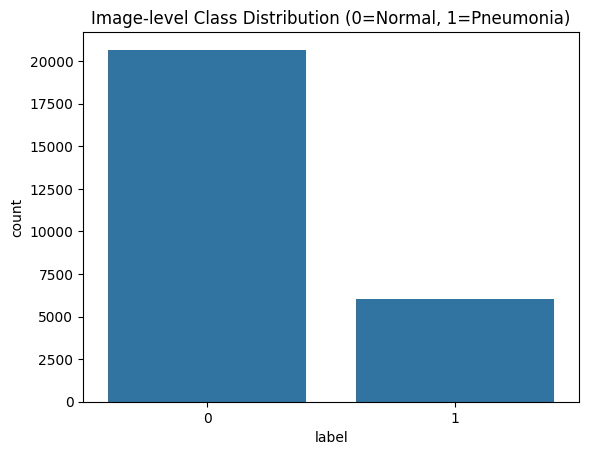

label
0    20672
1     6012
Name: count, dtype: int64
label
0    0.774696
1    0.225304
Name: proportion, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=df["label"])
plt.title("Image-level Class Distribution (0=Normal, 1=Pneumonia)")
plt.show()

print(df["label"].value_counts())
print(df["label"].value_counts(normalize=True))


In [ ]:
from sklearn.model_selection import train_test_split

# First split: Train vs Temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42
)

# Second split: Val vs Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (18678, 2)
Val: (4003, 2)
Test: (4003, 2)


In [ ]:
assert set(train_df.patientId).isdisjoint(val_df.patientId)
assert set(train_df.patientId).isdisjoint(test_df.patientId)
assert set(val_df.patientId).isdisjoint(test_df.patientId)

print("No patientId leakage between splits")


No patientId leakage between splits


In [ ]:
import os
import pydicom
import numpy as np
import random

TRAIN_IMG_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"


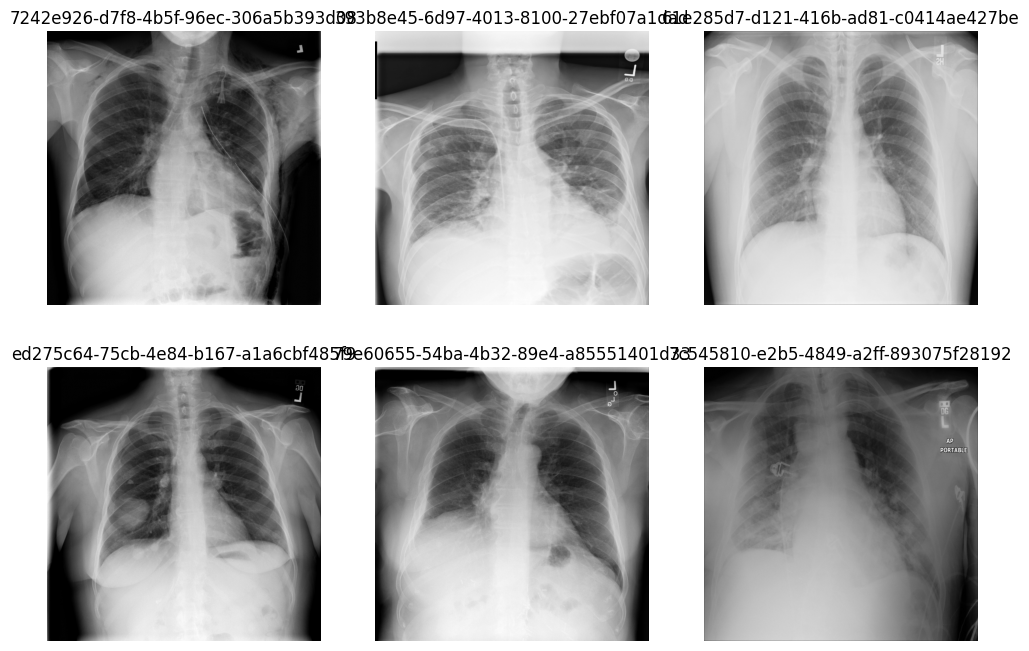

In [ ]:
sample_ids = random.sample(list(train_df["patientId"]), 6)

plt.figure(figsize=(12, 8))

for i, pid in enumerate(sample_ids):
    img = pydicom.dcmread(
        os.path.join(TRAIN_IMG_DIR, pid + ".dcm")
    ).pixel_array

    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(pid)
    plt.axis("off")

plt.show()


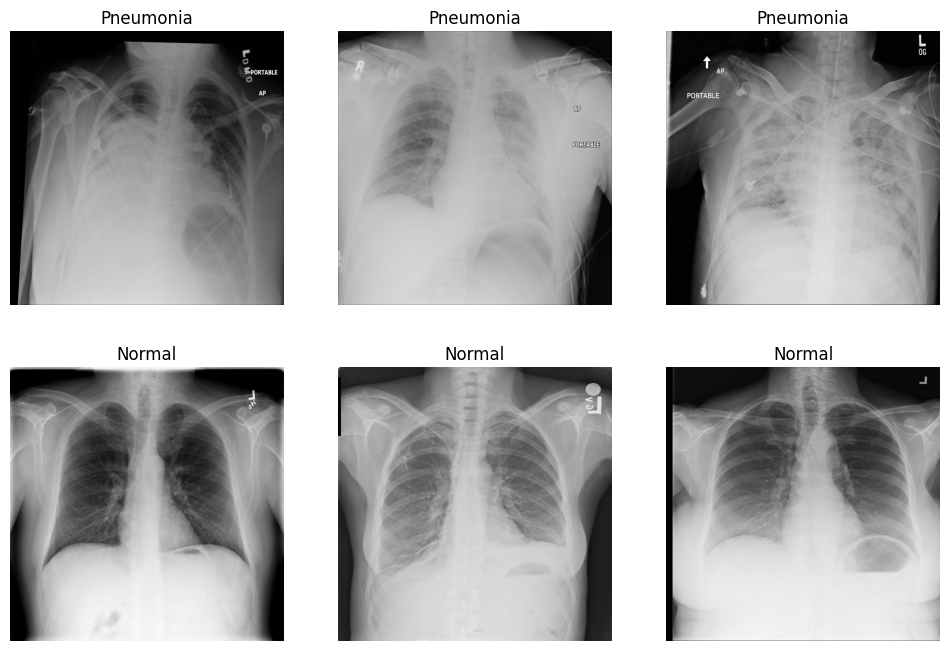

In [ ]:
p_ids = train_df[train_df["label"] == 1]["patientId"].sample(3)
n_ids = train_df[train_df["label"] == 0]["patientId"].sample(3)

ids = list(p_ids) + list(n_ids)

plt.figure(figsize=(12, 8))

for i, pid in enumerate(ids):
    img = pydicom.dcmread(
        os.path.join(TRAIN_IMG_DIR, pid + ".dcm")
    ).pixel_array

    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap="gray")
    plt.title("Pneumonia" if i < 3 else "Normal")
    plt.axis("off")

plt.show()


In [ ]:
def print_split_stats(name, df):
    print(f"{name} size:", len(df))
    print(df["label"].value_counts(normalize=True), "\n")

print_split_stats("Train", train_df)
print_split_stats("Val", val_df)
print_split_stats("Test", test_df)


Train size: 18678
label
0    0.774708
1    0.225292
Name: proportion, dtype: float64 

Val size: 4003
label
0    0.774669
1    0.225331
Name: proportion, dtype: float64 

Test size: 4003
label
0    0.774669
1    0.225331
Name: proportion, dtype: float64 



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

In [ ]:
class RSNADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pid = self.df.loc[idx, "patientId"]
        label = self.df.loc[idx, "label"]

        path = os.path.join(self.img_dir, pid + ".dcm")
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array

        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img = np.stack([img]*3, axis=-1).astype(np.uint8)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
print("hi")

hi


In [ ]:
BATCH_SIZE = 16

train_loader = DataLoader(
    RSNADataset(train_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    RSNADataset(val_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

test_loader = DataLoader(
    RSNADataset(test_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(
    "swin_base_patch4_window7_224",
    pretrained=True,
    num_classes=1
)

model.to(device)


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)


In [ ]:
import os
import cv2
import pydicom
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)


In [ ]:
EPOCHS = 40

THRESHOLD = 0.5

history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": [],
    "train_prec": [], "val_prec": [],
    "train_f1": [], "val_f1": [],
    "train_auc": [], "val_auc": []
}

best_loss = float("inf")
patience_ctr = 0

for epoch in range(EPOCHS):

    model.train()
    t_loss, t_probs, t_labels = [], [], []

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x = x.to(device)
        y = y.to(device).unsqueeze(1)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        t_loss.append(loss.item())
        t_probs.append(torch.sigmoid(logits).detach().cpu())
        t_labels.append(y.cpu())

    t_probs = torch.cat(t_probs).numpy()
    t_labels = torch.cat(t_labels).numpy()


    model.eval()
    v_loss, v_probs, v_labels = [], [], []

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            logits = model(x)
            loss = criterion(logits, y)

            v_loss.append(loss.item())
            v_probs.append(torch.sigmoid(logits).cpu())
            v_labels.append(y.cpu())

    v_probs = torch.cat(v_probs).numpy()
    v_labels = torch.cat(v_labels).numpy()

    def metrics(y_true, y_prob):
        y_pred = (y_prob > THRESHOLD).astype(int)
        return (
            accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred, zero_division=0),
            f1_score(y_true, y_pred, zero_division=0),
            roc_auc_score(y_true, y_prob)
        )

    t_acc, t_prec, t_f1, t_auc = metrics(t_labels, t_probs)
    v_acc, v_prec, v_f1, v_auc = metrics(v_labels, v_probs)

    history["train_loss"].append(np.mean(t_loss))
    history["val_loss"].append(np.mean(v_loss))
    history["train_acc"].append(t_acc)
    history["val_acc"].append(v_acc)
    history["train_prec"].append(t_prec)
    history["val_prec"].append(v_prec)
    history["train_f1"].append(t_f1)
    history["val_f1"].append(v_f1)
    history["train_auc"].append(t_auc)
    history["val_auc"].append(v_auc)

    print(
        f"Epoch {epoch+1} | "
        f"Train Loss {np.mean(t_loss):.5f} | "
        f"Val Loss {np.mean(v_loss):.5f} | "
        f"Val AUC {v_auc:.5f}"
    )


    best_loss = np.mean(v_loss)
    patience_ctr = 0
    torch.save(model.state_dict(), "best_swin_stage1.pth")


Epoch 1 [Val]: 100%|██████████| 251/251 [00:59<00:00,  4.19it/s]


Epoch 1 | Train Loss 0.42567 | Val Loss 0.38443 | Val AUC 0.86719


Epoch 2 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.39it/s]


Epoch 2 | Train Loss 0.37215 | Val Loss 0.37207 | Val AUC 0.86593


Epoch 3 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.48it/s]


Epoch 3 | Train Loss 0.34222 | Val Loss 0.36730 | Val AUC 0.86312


Epoch 4 [Val]: 100%|██████████| 251/251 [00:37<00:00,  6.62it/s]


Epoch 4 | Train Loss 0.29359 | Val Loss 0.37360 | Val AUC 0.86325


Epoch 5 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.37it/s]


Epoch 5 | Train Loss 0.22092 | Val Loss 0.46675 | Val AUC 0.84959


Epoch 6 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.48it/s]


Epoch 6 | Train Loss 0.14711 | Val Loss 0.48715 | Val AUC 0.82321


Epoch 7 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.53it/s]


Epoch 7 | Train Loss 0.09942 | Val Loss 0.57271 | Val AUC 0.84082


Epoch 8 [Val]: 100%|██████████| 251/251 [00:45<00:00,  5.49it/s]


Epoch 8 | Train Loss 0.07778 | Val Loss 0.79930 | Val AUC 0.84183


Epoch 9 [Val]: 100%|██████████| 251/251 [00:40<00:00,  6.16it/s]


Epoch 9 | Train Loss 0.06219 | Val Loss 0.99599 | Val AUC 0.82873


Epoch 10 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.41it/s]


Epoch 10 | Train Loss 0.05444 | Val Loss 0.75864 | Val AUC 0.84564


Epoch 11 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.42it/s]


Epoch 11 | Train Loss 0.04883 | Val Loss 0.79833 | Val AUC 0.83236


Epoch 12 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.30it/s]


Epoch 12 | Train Loss 0.04134 | Val Loss 0.74955 | Val AUC 0.83976


Epoch 13 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.33it/s]


Epoch 13 | Train Loss 0.04634 | Val Loss 0.89090 | Val AUC 0.83896


Epoch 14 [Val]: 100%|██████████| 251/251 [00:40<00:00,  6.24it/s]


Epoch 14 | Train Loss 0.04704 | Val Loss 1.05746 | Val AUC 0.83231


Epoch 15 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.39it/s]


Epoch 15 | Train Loss 0.03666 | Val Loss 1.23615 | Val AUC 0.82651


Epoch 16 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.30it/s]


Epoch 16 | Train Loss 0.04586 | Val Loss 1.05635 | Val AUC 0.83615


Epoch 17 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.28it/s]


Epoch 17 | Train Loss 0.03175 | Val Loss 1.01938 | Val AUC 0.82955


Epoch 18 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.34it/s]


Epoch 18 | Train Loss 0.03596 | Val Loss 0.86798 | Val AUC 0.83022


Epoch 19 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.32it/s]


Epoch 19 | Train Loss 0.03631 | Val Loss 1.16744 | Val AUC 0.83351


Epoch 20 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.32it/s]


Epoch 20 | Train Loss 0.05291 | Val Loss 0.77844 | Val AUC 0.83829


Epoch 21 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.34it/s]


Epoch 21 | Train Loss 0.02396 | Val Loss 0.91855 | Val AUC 0.82996


Epoch 22 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.37it/s]


Epoch 22 | Train Loss 0.02852 | Val Loss 0.92377 | Val AUC 0.84689


Epoch 23 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.43it/s]


Epoch 23 | Train Loss 0.03002 | Val Loss 0.86902 | Val AUC 0.82592


Epoch 24 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.46it/s]


Epoch 24 | Train Loss 0.03652 | Val Loss 0.93164 | Val AUC 0.83468


Epoch 25 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.54it/s]


Epoch 25 | Train Loss 0.02665 | Val Loss 1.14362 | Val AUC 0.84426


Epoch 26 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.55it/s]


Epoch 26 | Train Loss 0.03212 | Val Loss 0.84675 | Val AUC 0.82803


Epoch 27 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.58it/s]


Epoch 27 | Train Loss 0.03121 | Val Loss 0.90080 | Val AUC 0.84297


Epoch 28 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.50it/s]


Epoch 28 | Train Loss 0.02916 | Val Loss 0.74982 | Val AUC 0.83681


Epoch 29 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.59it/s]


Epoch 29 | Train Loss 0.02760 | Val Loss 1.16769 | Val AUC 0.83306


Epoch 30 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.58it/s]


Epoch 30 | Train Loss 0.03000 | Val Loss 1.03912 | Val AUC 0.84012


Epoch 31 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.48it/s]


Epoch 31 | Train Loss 0.03130 | Val Loss 1.03029 | Val AUC 0.82572


Epoch 32 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.31it/s]


Epoch 32 | Train Loss 0.02804 | Val Loss 0.99884 | Val AUC 0.83193


Epoch 33 [Val]: 100%|██████████| 251/251 [00:40<00:00,  6.14it/s]


Epoch 33 | Train Loss 0.02048 | Val Loss 1.05586 | Val AUC 0.83917


Epoch 34 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.30it/s]


Epoch 34 | Train Loss 0.03003 | Val Loss 0.92769 | Val AUC 0.83115


Epoch 35 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.47it/s]


Epoch 35 | Train Loss 0.02608 | Val Loss 0.75371 | Val AUC 0.83341


Epoch 36 [Val]: 100%|██████████| 251/251 [00:37<00:00,  6.62it/s]


Epoch 36 | Train Loss 0.02545 | Val Loss 0.86859 | Val AUC 0.84470


Epoch 37 [Val]: 100%|██████████| 251/251 [00:37<00:00,  6.62it/s]


Epoch 37 | Train Loss 0.02121 | Val Loss 1.13022 | Val AUC 0.83341


Epoch 38 [Val]: 100%|██████████| 251/251 [00:37<00:00,  6.65it/s]


Epoch 38 | Train Loss 0.02771 | Val Loss 1.31867 | Val AUC 0.83364


Epoch 39 [Val]: 100%|██████████| 251/251 [00:38<00:00,  6.59it/s]


Epoch 39 | Train Loss 0.02236 | Val Loss 0.99573 | Val AUC 0.81696


Epoch 40 [Val]: 100%|██████████| 251/251 [00:39<00:00,  6.43it/s]


Epoch 40 | Train Loss 0.03123 | Val Loss 0.75568 | Val AUC 0.84061


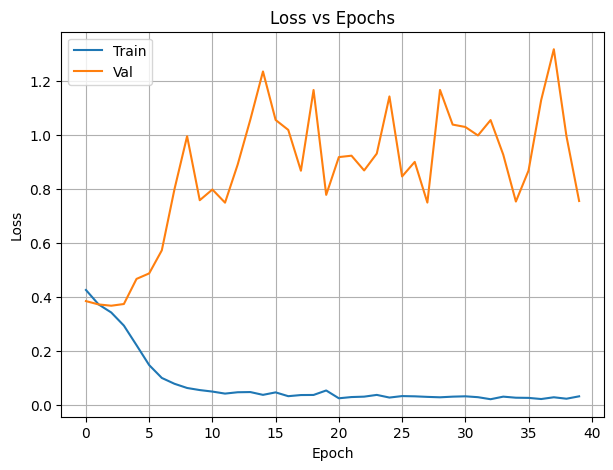

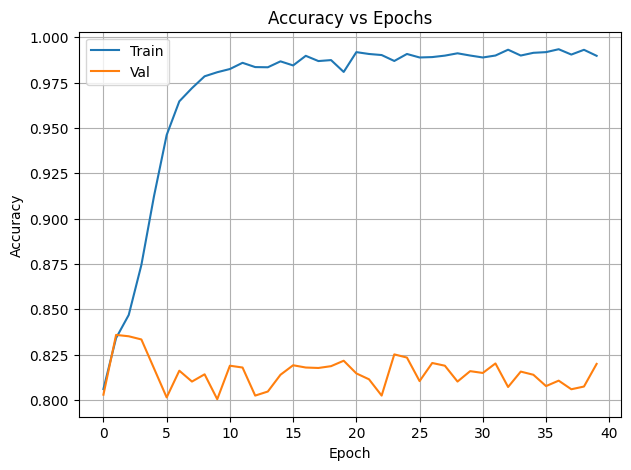

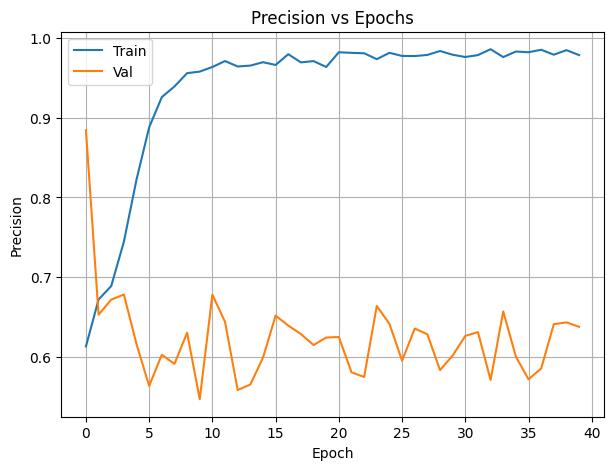

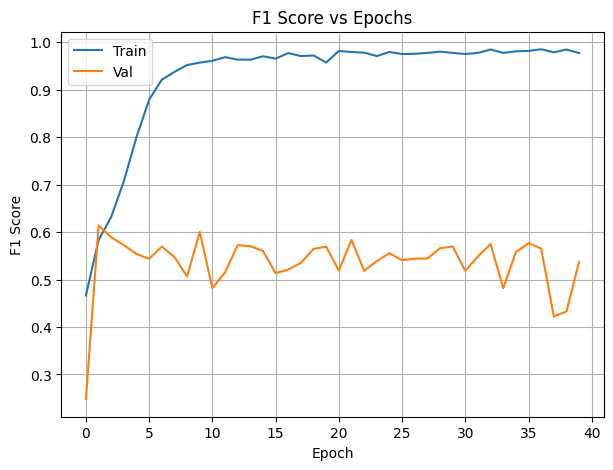

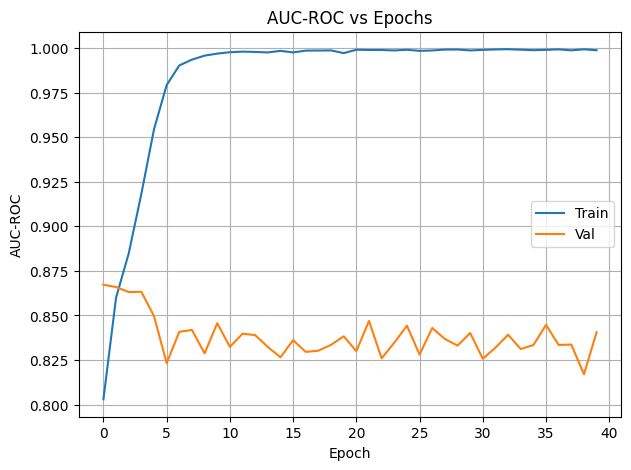

In [ ]:
def plot_metric(name, ylabel):
    plt.figure(figsize=(7,5))
    plt.plot(history[f"train_{name}"], label="Train")
    plt.plot(history[f"val_{name}"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs Epochs")
    plt.legend()
    plt.grid()
    plt.show()

plot_metric("loss", "Loss")
plot_metric("acc", "Accuracy")
plot_metric("prec", "Precision")
plot_metric("f1", "F1 Score")
plot_metric("auc", "AUC-ROC")


In [ ]:
model.load_state_dict(torch.load("best_swin_stage1.pth"))
model.eval()

probs, labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        probs.append(torch.sigmoid(logits).cpu())
        labels.append(y.unsqueeze(1))

probs = torch.cat(probs).numpy()
labels = torch.cat(labels).numpy()
preds = (probs > THRESHOLD).astype(int)


In [ ]:
print(classification_report(labels, preds, digits=5))


              precision    recall  f1-score   support

         0.0    0.86766   0.91970   0.89292      3101
         1.0    0.65223   0.51774   0.57726       902

    accuracy                        0.82913      4003
   macro avg    0.75995   0.71872   0.73509      4003
weighted avg    0.81912   0.82913   0.82179      4003



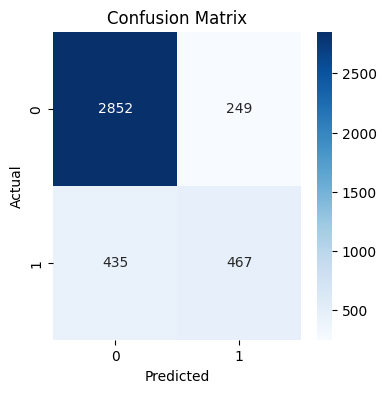

In [ ]:
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


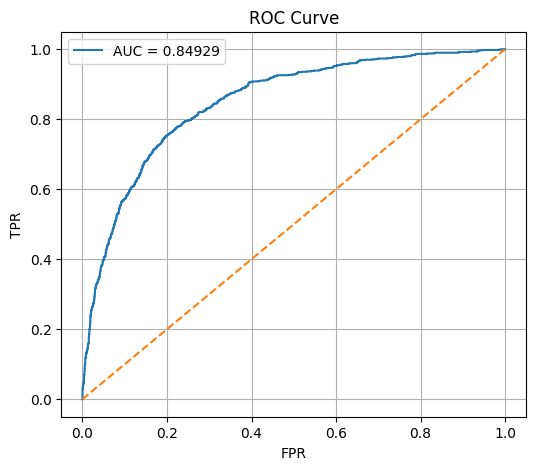

In [ ]:
fpr, tpr, _ = roc_curve(labels, probs)
auc = roc_auc_score(labels, probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.5f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()
